Welcome to google collab! If you are not familiar with the collab notebooks, I hope you will be positively surprised :)  

Please:
- Copy this notebook into your own drive (File->Save a copy to drive)
- Look into this original notebook anyway you wish, it does contain our saved run
- Run it 
  - And feel free to select Runtime->Change runtime type into a GPU accelerated workstation :)

# Autoencoders - quick theory and live examples

![autoencoder image](https://www.researchgate.net/publication/318204554/figure/fig1/AS:512595149770752@1499223615487/Autoencoder-architecture.png)   
(Image from https://www.researchgate.net/publication/318204554_Intelligent_condition_monitoring_method_for_bearing_faults_from_highly_compressed_measurements_using_sparse_over-complete_features/figures?lo=1)  

  
Autoencoder is a model, that (is trained to) map outputs to be as similar as inputs as possible.  
Keys:
- Unsupervised learning
- The point is in the architecture, because it is not an identity function
 - But we can say identity-like with 'bottleneck'
- has 2 parts:
 - encoder (maps input to inner representation)
 - decoder (maps inner representation to output)
- both parts trained together to reduce input-output error
- were used for pretraining a deeper models (as in image, each part trained alone)
  - ![alt text](https://www.researchgate.net/profile/Francois_Pachet/publication/319524552/figure/fig21/AS:535791140708363@1504753970877/Stacked-autoencoders-architecture_W640.jpg)
- now used for dimensionality reduction and other usecases (covered here as ecamples)  

## Autoencoder live demos

In [5]:
from IPython.display import IFrame
IFrame('https://cs.stanford.edu/people/karpathy/convnetjs/demo/autoencoder.html', width=900, height=350)

In [6]:
# Not exactly an autoencoder, only when you think that the input and output are images and the bottleneck is, that it is able to use just positions.
IFrame('https://cs.stanford.edu/people/karpathy/convnetjs/demo/image_regression.html', width=900, height=350)

In [7]:
IFrame('https://magenta.tensorflow.org/assets/sketch_rnn_demo/multi_vae.html', width=900, height=350)

In [4]:
IFrame('https://transcranial.github.io/keras-js/#/mnist-vae', width=900, height=350)

# Autoencoders and text data - Experiments

### What we would like to cover:
- Autoencoders usage on texts with word by word representation
- **How to work with autoencoders, how to use them and analyze them. (As opposed to 'how to build an anutoencoder to reach a given goal')**
  - we will specifically aim to use the most basic autoencoder (see image at the top)
  - ... and do not scroll to the bottom immediately, there are spoilers :)
    
Note:
- The usual flow of experimental work would be to experiment (proof of work) on training data and validate/test on testing data.
  - Note, that here we do only experiments on training data

## Preparation of the environment + imports

In [0]:
!pip install bhtsne  # for visualizations with TSNE

    100% |████████████████████████████████| 92kB 5.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/d3/11/da/b469506296148e4a04bb3bd5083052a2c5d44709851ed17c21
Successfully built bhtsne


In [1]:
import unicodedata
import sys
import numpy as np
import tempfile
from six import string_types, reraise
from copy import copy
import os
import re
from tqdm import tqdm
from keras.layers import Input, Dense, Dropout, Flatten, Reshape
from keras.models import Model
import matplotlib.pyplot as plt

import chardet
from bhtsne import tsne  #https://github.com/dominiek/python-bhtsne
from sklearn.cluster import Birch


class tempmap(np.memmap):
  """
  Just a helper class for memmap numpy arrays to stay in the temporary directory.
  """
  def __new__(subtype, dtype=np.uint8, mode='w+', offset=0,
              shape=None, order='C'):
      ntf = tempfile.NamedTemporaryFile()
      self = np.memmap.__new__(subtype, ntf, dtype, mode, offset, shape, order)
      self.temp_file_obj = ntf
      return self

  def __del__(self):
      if hasattr(self,'temp_file_obj') and self.temp_file_obj is not None:
          self.temp_file_obj.close()
          # del self.temp_file_obj

Using TensorFlow backend.


## IMDB Dataset download & inspection

At this point, any dataset can be used, we have decided to use a dataset of IMDB movie reviews.

In [12]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar xfz aclImdb_v1.tar.gz

--2019-02-22 11:33:58--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  1.04MB/s    in 1m 48s  

2019-02-22 11:35:49 (760 KB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [2]:
# Vocabulary: Loads all words used, starting by the most frequent.
# We need the vocabulary only for displaying the results.
vocab_cut = 20000 # Keep only most frequent words rather than all

with open('aclImdb/imdb.vocab', "rb") as f:
    rawdata=f.read()
    
    # automatic inspect of the encoding and data, in case we forget :)
    print(chardet.detect(rawdata))
    f.seek(0)
    vocab = [word.decode("utf8").rstrip() for word in f]
    
    # Just saving memory - the long tail occurs too few times
    # for the model to learn anything anyway
    vocab = vocab[:vocab_cut]
    print('%d words in vocabulary' % (len(vocab),))
    print(type(vocab[0]))

# append some number to the vocabulary (for disaplying resons, does not affect training)
for i in range(99):
  vocab.append(str(i))

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}
20000 words in vocabulary
<class 'str'>


## Nonautoencoder baseline and helper functions

The text processing should employ tokenization of the text and some helper functions like deaccenting, because autoencoders (and other text procesing algorithms and models in ML) do not work with text naturally.  
  
 Generally we have more options:  
 1. Embedd each word into defined dimensional space by a trained embedding.
 2. Put onehot representation of each word or character into the network
 3. Use 'feature vectors' for each word
   
For our first try with ML model, lets use feature vectors.
- the feature vector generator does not use memory as much as embeddings
- feature vectors are 'fair' to our model, meaning that embeddings are usually pretrained and will already bear more information
- every word has its feature vector (as opposed to the fact, that not all words have an embedding)
- character level models can be a tiny bit harder to understand or train
  
Feature vector function used here ('features_from_text') is usually used for a text analysis task, because it does count the number of lowercase/uppercase letter/digits and character frequencies.  

With this function we are, moreover, able to lookup back into a dictionary (will be shown).

In [3]:
def text_tokens(text):
  """
  Tokenization is the proces that turns a text sentence into a sequence of tokens,
  i.e. decides what is a word and what is a separator.
  """  
  text = re.sub("\\s", " ", text)
  text = re.sub("<br/>", " ", text)
  text = re.sub("<br />", " ", text)
  text = re.sub("<br>", " ", text)
  #text = re.sub("[^a-zA-Z' ]", "", text)
  tokens = re.split('(\W+)', text) # text.split(' ')
  tokens = [re.sub(" ", "", token) for token in tokens if token not in [' ', '']]
  return tokens

# This is our vocabulary of characters we will work with, other will be forgotten
default_char_list = u' abcdefghijklmnopqrstuvwxyz0123456789,.-+:/%?$£€#()&\''
default_char_vocab = {letter: i for i, letter in enumerate(list(default_char_list))}


def remove_accents(input_str):
  """
  We do not want accents and special characters, so lets normalize the text.
  """
  try:
      # variant:
      # unicoded = unicode(input_char)
      # # .decode('utf-8', 'ignore')
      # nfkd_form = unicodedata.normalize('NFKD', unicoded)
      # only_ascii = nfkd_form.encode('ASCII', 'ignore')
      # if len(only_ascii) <= 0:
      #    return nfkd_form

      if len(input_str) == 0:
        return u""
      unistr = input_str.replace(u'\xf8', u'o')
      unistr = unistr.replace(u'\xd8', u'O')

      unistr = "".join(aChar
                     for aChar in unicodedata.normalize("NFD", unistr)
                     if not unicodedata.combining(aChar))
      return unistr
  except Exception as e:
      print("at {}".format(input_str))
      reraise(type(e), e, sys.exc_info()[2])

        
def base_text_features(text, features=['len', 'upper', 'lower', 'alpha', 'digit'],
                       scale=20,
                       char_vocab=default_char_vocab):
  """
  Function, that extract features from the given text based on given parameters.
  If character vocabulary is given, the features contain character frequencies.
  """
  def text_histogram(text, char_vocab=default_char_vocab,
                     char_vocab_make_lower=True):
      hist = [0] * len(default_char_vocab.keys())
      for letter in text:
          if char_vocab_make_lower:
              luse = letter.lower()
          else:
              luse = letter
          luse = remove_accents(luse)
          if luse in default_char_vocab:
              hist[default_char_vocab[luse]] += 1
      return hist

  def count_uppers(text):
      return sum([letter.isupper() for letter in text])

  def count_lowers(text):
      return sum([letter.islower() for letter in text])

  def count_alphas(text):
      return sum([letter.isalpha() for letter in text])

  def count_digits(text):
      return sum([letter.isdigit() for letter in text])

  use_cases = {
      'len': len,
      'upper': count_uppers,
      'lower': count_lowers,
      'alpha': count_alphas,
      'digit': count_digits,
  }
  repr = [use_cases[feature](text) for feature in features]
  if char_vocab is not None:
      repr.extend(text_histogram(text, default_char_vocab))

  if scale is not None:
      for i in range(len(repr)):
          repr[i] = min(repr[i] / scale, 1.0)

  return repr


def features_from_text(text, values_scales=[100.0], scale=20):
  """
  Lets extract features from the whole word, beginning of a word and ending of a word.
  (Also if the given word is a number, lets scale it into [0,1] interval;
  this should help the network with text, that does come after a number as '1 st')
  """
  try:
      xtextasval = float(text.replace(" ", "").replace("%", ""))
      xtextisval = 1.0
      assert np.isfinite(xtextasval)
  except:
      xtextasval = 0.0
      xtextisval = 0.0
  if xtextisval > 0.0:  # is actually a value
      xtextasval = [min(xtextasval / scale, 1.0) for scale in values_scales]
  else:
      xtextasval = [0.0] * len(values_scales)

  allfeats = base_text_features(text, scale=scale, features=['len', 'upper', 'lower', 'alpha', 'digit'])
  if len(text) <= 1:
      # just if we use the histograms for first two letters and last two letters, what to do in smaller
      text_to_handle = " " + text + " "
  else:
      text_to_handle = text
  begfeats = base_text_features(text_to_handle[0:2], scale=scale, features=['upper', 'lower', 'alpha', 'digit'])
  endfeats = base_text_features(text_to_handle[-2:0], scale=scale, features=['upper', 'lower', 'alpha', 'digit'])

  return allfeats + begfeats + endfeats + xtextasval + [xtextisval]


print("Lets test our code:")
print("Does tokenization leave a word in a vocabulary alone?: {}".
      format(text_tokens(vocab[1552])))
print(u"Word '{}' is, for example, translated as {} ".format(vocab[1552], features_from_text(vocab[1552])))
print(u"Words '{}' is deaccented as {}".format(vocab[1552], remove_accents(vocab[1552])))

Lets test our code:
Does tokenization leave a word in a vocabulary alone?: ['cliché']
Word 'cliché' is, for example, translated as [0.3, 0.0, 0.3, 0.3, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.05, 0.0, 0.0, 0.05, 0.05, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

When using any form of inner representations, we would need to have a function, that rewrites the inner representation into an existing word to be understandable for us.  

In [4]:
def vocab_finder(item, vocab, key_f=None, apply_on_item_too=True):
  """
  A modular function to allow for searching an item against vocabulary of items
  based on the minimal distance. 
  The modularity allows for applying a function over the vocabulary
  or query items.
  """
  if apply_on_item_too:
      fitem = key_f(item) if key_f else item
  else:
      fitem = item
  mindiff = None
  minitem = None
  
  for v, vitem in enumerate(vocab):
      fvitem = key_f(vitem) if key_f else vitem
      
      diff = np.mean(np.square(np.asarray(fitem) - np.asarray(fvitem)))        
      if mindiff is None or diff < mindiff:
          mindiff = diff
          minitem = (v, vitem)
  return minitem, mindiff


print("A test that/how the vocabulary search works: \n")
print(vocab_finder("the", vocab, features_from_text))
print(vocab_finder("nonsensualword", vocab, features_from_text))
print(vocab_finder("potential", vocab, features_from_text))
print("")
print("Idea: Try to think about the feature vector as a hash and find collisions in the provided hashing over the vocabulary")
print("Idea: Try the code with bigger/smaller vocabulary")

A test that/how the vocabulary search works: 

((0, 'the'), 0.0)
((15379, 'unprofessional'), 0.0001149425287356322)
((948, 'potential'), 0.0)

Idea: Try to think about the feature vector as a hash and find collisions in the provided hashing over the vocabulary
Idea: Try the code with bigger/smaller vocabulary


## Dataset preparation

We will load a small subset of the dataset (can be increased for speed tradeoff :) )  and process it together with vocabulary with our feature vectors.

In [5]:
def load_dataset(dirname, train_set_slice_size=5000):
  """
  Loads and tokenizes a dataset into a list.
  Label loading included, even though we will not use it for autoencoders.
  Set train_set_slice_size to 500 for fast tryout.
  """
  X, y = [], []
  # Review files: neg/0_3.txt neg/10000_4.txt neg/10001_4.txt ...
  for y_val, y_label in enumerate(['neg', 'pos']):
      y_dir = os.path.join(dirname, y_label)
      for fname in os.listdir(y_dir):
          fpath = os.path.join(y_dir, fname)
          with open(fpath) as f:
              tokens = text_tokens(f.read())            
          X.append(tokens)            
          y.append(y_val)  # 0 for 'neg', 1 for 'pos'

          if len(X) >= train_set_slice_size:
            break
      if len(X) >= train_set_slice_size:
        break
  return X, y

print("loading dataset")
X_train_orig, y_train = load_dataset('aclImdb/train/')
print("The loaded dataset has length {} \n sample tokenized sentence from dataset is: {}"
      .format(len(X_train_orig), X_train_orig[0]))

loading dataset
The loaded dataset has length 5000 
 sample tokenized sentence from dataset is: ['Absolutely', 'dreadful', 'Mexican', 'film', 'supposedly', 'based', 'on', 'a', 'short', 'story', 'by', 'Edgar', 'Allan', 'Poe', 'about', 'a', 'newsman', 'wanting', 'to', 'go', 'into', 'the', 'confines', 'of', 'an', 'asylum', 'hidden', 'in', 'the', 'woods', 'to', 'write', 'a', 'story', 'about', 'how', 'it', 'works', ',', 'etc', '...', 'When', 'our', 'hero', ',', 'Gaston', ',', 'is', 'given', 'the', 'grand', 'show', 'by', 'Dr', '.', 'Maillard', ',', 'head', 'of', 'the', 'asylum', ',', 'we', 'see', 'all', 'kinds', 'of', 'things', 'which', 'are', 'suppose', 'to', 'be', 'horrific', ',', 'such', 'as', 'men', 'hanging', 'around', 'long', 'in', 'a', 'dungeon', ',', 'and', 'comedic', ',', 'such', 'as', 'our', 'hero', 'being', 'joked', 'upon', 'by', 'soldiers', 'as', 'he', 'climbs', 'down', 'a', 'ladder', 'hanging', 'over', 'the', 'side', 'of', 'a', 'building', '.', 'Then', 'there', 'is', 'one', 'sig

In [6]:
def prepare_dataset_with_embeddings(vocab,
                                    embedd_f=features_from_text,
                                    X_train=X_train_orig):
  """
  Uses selected embedding function (which is here our feature vector function)
  and turns dataset and vocabulary into its embedding.  
  """
  shape = [len(X_train), max(len(text) for text in X_train)] + [len(embedd_f("default"))]

  print("Padded shape of training set is {}".format(shape))
  print("Running embedding function over the dataset ...")

  train_data = tempmap(shape=tuple(shape), dtype=np.float32) #np.zeros(shape)
  for i, sentence in tqdm(enumerate(X_train), total=len(X_train)):
      for j, word in enumerate(sentence):
          train_data[i, j, :] = embedd_f(word)
  print("Dataset prepared with embeddings into shape {}".
        format(train_data.shape))
  
  print("Running embedding function over the vocabulary ...")
  vocab_embedds = [(embedd_f(word), word) for word in vocab]
  print("Done ...")
  return train_data, vocab_embedds

print("Embeddings: creating dataset of floats from dataset of tokenized texts:")
train_data, vocab_embedds = prepare_dataset_with_embeddings(vocab,
                                                             features_from_text)

  0%|          | 11/5000 [00:00<01:45, 47.39it/s]

Embeddings: creating dataset of floats from dataset of tokenized texts:
Padded shape of training set is [5000, 1654, 174]
Running embedding function over the dataset ...


100%|██████████| 5000/5000 [02:10<00:00, 37.38it/s]


Dataset prepared with embeddings into shape (5000, 1654, 174)
Running embedding function over the vocabulary ...
Done ...


## Autoencoders on embeddings/feature vectors:
We will use the most simple autoencoder architecture, that just flattens the representation, runs it through a bottleneck with a dropout, then decodes and inflates again.  
![architecture](https://drive.google.com/uc?export=view&id=1KMfr0cLY3cvp9KbqOjiQQZM9Ae7LK7MP)  
(Image source: http://uksim.info/isms2016/CD/data/0665a174.pdf)  
  
The dropout mechanism  
![dropout](https://drive.google.com/uc?export=view&id=1nYxmBMIx3QPFqBw-Q1hJOr-Hvi7ASx7d)  

(Dropout illustration from https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2 )

In [7]:
def basic_autoencoder_architecture(window_size, encoding_dim,
                                   train_data_shape):
  """  
  Copied more or less from the keras blog:
  https://blog.keras.io/building-autoencoders-in-keras.html
  
  encoding_dim is the size of our encoded representations
  """
  inp_shape = window_size * train_data_shape[-1]  # flattened representation size

  print("Architecture will compress data to {} fraction"
        .format(encoding_dim / inp_shape))

  # this is our input placeholder
  input_data = Input(shape=(window_size, train_data_shape[-1], ))
  input_flat = Flatten()(input_data)
  # "encoded" is the encoded representation of the input
  encoded = Dense(encoding_dim, activation='tanh')(Dropout(0.15)(input_flat))
  
  # defined order of layers to apply when building atuencoder.
  # If we instantiate the layers now and then only apply them functionally,
  # they will share their (trained) weights
  decoder_layers = [Dense(inp_shape, activation='tanh'),
                    Reshape((window_size, train_data_shape[-1]))]
  def apply_decoder_layers(inner_input):
    out = inner_input
    for layer in decoder_layers:
      out = layer(out)
    return out

  # this model maps an input to its reconstruction
  autoencoder = Model(input_data, apply_decoder_layers(encoded))

  # this model maps an input to its encoded representation
  encoder = Model(input_data, encoded)

  # create a placeholder for an encoded input
  encoded_input = Input(shape=(encoding_dim,))

  # create the decoder model
  decoder = Model(encoded_input, apply_decoder_layers(encoded_input))

  autoencoder.compile(optimizer='adam', loss='mse')
  return autoencoder, encoder, decoder


def train_and_predict(architecture_f,
                      train_data,
                      window_size,
                      valid_split_size=100, 
                      epochs=100, batch_size=100, **kwargs): 
    """
    The definition of the training process, which will create the autoencoder and
    then run training.
    Also processes training set into its inner representation in the autoencoder.
    Outputs not only the autoencoder, but also the encoder and decoder.
    """
    print(kwargs)
    autoencoder, encoder, decoder = architecture_f(window_size=window_size, **kwargs)
    
    x_train = train_data[:-valid_split_size, :window_size, :].astype('float32')
    x_test  = train_data[-valid_split_size:, :window_size, :].astype('float32')
    #x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    #x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    print(x_train.shape)
    print(x_test.shape)

    autoencoder.fit(x_train, x_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test))

    x_train_pred = encoder.predict(x_train)
    x_test_pred = encoder.predict(x_test)
    print("Predicted data on training and test")
    return x_train_pred, x_test_pred, autoencoder, encoder, decoder


x_train_pred, x_test_pred, autoencoder, encoder, decoder = \
    train_and_predict(basic_autoencoder_architecture,
                      train_data=train_data,
                      window_size=20,
                      encoding_dim=800,
                      train_data_shape=train_data.shape,
                     )

{'encoding_dim': 800, 'train_data_shape': (5000, 1654, 174)}
Architecture will compress data to 0.22988505747126436 fraction
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(4900, 20, 174)
(100, 20, 174)
Instructions for updating:
Use tf.cast instead.
Train on 4900 samples, validate on 100 samples
Epoch 1/100
4900/4900 [==============================] - 1s 268us/step - loss: 6.9342e-04 - val_loss: 3.9070e-04
Epoch 2/100
4900/4900 [==============================] - 0s 79us/step - loss: 3.5612e-04 - val_loss: 2.3964e-04
Epoch 3/100
4900/4900 [==============================] - 0s 78us/step - loss: 2.3352e-04 - val_loss: 1.6594e-04
Epoch 4/100
4900/4900 [==============================] - 0s 77us/step - loss: 1.9204e-04 - val_loss: 1.4423e-04
Epoch 5/100
4900/4900 [==============================] - 0s 75us/step - loss: 1.7085e-04 - val_loss: 1.2899e-04
E

4900/4900 [==============================] - 0s 75us/step - loss: 4.9295e-05 - val_loss: 2.8625e-05
Epoch 63/100
4900/4900 [==============================] - 0s 75us/step - loss: 4.7995e-05 - val_loss: 2.8557e-05
Epoch 64/100
4900/4900 [==============================] - 0s 74us/step - loss: 4.7594e-05 - val_loss: 2.8575e-05
Epoch 65/100
4900/4900 [==============================] - 0s 74us/step - loss: 4.7909e-05 - val_loss: 2.7982e-05
Epoch 66/100
4900/4900 [==============================] - 0s 75us/step - loss: 4.8156e-05 - val_loss: 2.8408e-05
Epoch 67/100
4900/4900 [==============================] - 0s 75us/step - loss: 4.7820e-05 - val_loss: 2.7422e-05
Epoch 68/100
4900/4900 [==============================] - 0s 75us/step - loss: 4.8471e-05 - val_loss: 2.7706e-05
Epoch 69/100
4900/4900 [==============================] - 0s 76us/step - loss: 4.8468e-05 - val_loss: 2.7311e-05
Epoch 70/100
4900/4900 [==============================] - 0s 75us/step - loss: 4.7136e-05 - val_loss: 2.7607e

# Evaluating and usages basics:  
  
We have trained an autoencoder. Now lets go through some basic usecases and deduct what is the autoencoder doing! In each case we will also pint out what shoukd be the best non-toy model fo that task. 
(Can we guess now, what is the toy autoencoder doing?)  
  
Hints we could know from the architecture are:
- Not every autoencoder is suitable for every task, so some of usecases can be misleading in our detective work
- The autoencoder is the most basic one, so it would not do fancy stuff
  - Analogy in the world of CNNs for images is, that only the deep layers do recognize objects or faces.
- The given features are balanced to every character, they should not favor anything

### Looking at how the autoencoder handles a sentence from the training set
Real usecases can be data compression, pretraining layers for bigger model, machine translation, or just a test for ruling out bad architectures.  
Also there is a class of denoising autoencoders which should not only reconstruct a sentence, but also to repair a modified sentence (reconstruct randomly altered input)
*Best used: *

In [8]:
def simply_word_in_embedd_vocab(item, vocab_embedds):
  """
  Lets use the vocabulary search to get just the word from the ()predicted) features.
  """
  search_result = vocab_finder(item, vocab_embedds, key_f=lambda item: item[0],
                               apply_on_item_too=False)
  # search_result = ((ith position, the vocabulary item), score)
  # the vocabulary item is (embedd_f(word), word)
  
  return search_result[0][1][1]
 

def compare_reconstructed(batch,
                          autoencoder=autoencoder,
                          emb2text=lambda emb: simply_word_in_embedd_vocab(emb, vocab_embedds),
                          verbose=True
                         ):
    """
    This function would compare the original sentence to:
    - a sentence reconstructed without the autoencoder, just from word features and vocabulary
    - a sentence reconstructed using the autoencoder

    Also we can measure the MSE of the original and the reconstructed
    (without using the vocabulary to separate the effects).
    """
    prediction = autoencoder.predict_on_batch(batch)
    
    ret = []
    
    for pred_item, batch_item in zip(prediction, batch):
        word_by_word  = batch_item #np.reshape(batch_item, (-1, train_data.shape[-1]))
        orig = u" ".join([emb2text(word) for word in word_by_word])
               
        pred_by_word  = pred_item #np.reshape(pred_item, (-1, train_data.shape[-1]))
        pred = u" ".join([emb2text(word) for word in pred_by_word])
    
        mse = np.mean(np.square(word_by_word - pred_by_word))
        if verbose:
          print(u"\n \n --Original sentence reconstructed just from vocabulary: \n"
          "{}\n"
          "--Predicted sentence reconstructed by autoencoder AND vocabulary: \n"
          "{}\n"
          "--mse: {}; ({})\n".format(orig, pred, mse,
                                  u"(different)" if orig != pred else u"same"))
        ret.append((orig, pred, mse))
    return ret


print("2 things from training set:")
compare_reconstructed(train_data[0:2, :20])
print(" ... seems pretty OK")

2 things from training set:

 
 --Original sentence reconstructed just from vocabulary: 
absolutely dreadful mexican film supposedly based on a short story by edgar allan poe about a newman wanting to go
--Predicted sentence reconstructed by autoencoder AND vocabulary: 
absolute dreadful mencia film supposedly based on a short story by edgar allan poe about a newman wanting to go
--mse: 2.042603045993019e-05; ((different))


 
 --Original sentence reconstructed just from vocabulary: 
i found darkness to be just too add ! it had a kind of cool idea and some ambitious ideas
--Predicted sentence reconstructed by autoencoder AND vocabulary: 
i found sanders to be just too rad ! it had a kind of cool idea and some ambitious ideas
--mse: 1.6929163393797353e-05; ((different))

 ... seems pretty OK


### Generating random sentence with the model:
Given random inner representation, it should produce a random sentence.  
Usefull also for randomly altering a sentence.  

*Best used: for non-toy example, more suitable autoencoder architecture should be the VAE (Variational autoencoder), possibly with embeddings.*

In [9]:
def generate_from_inner(batch,
                          decoder=decoder,
                          emb2text=lambda emb: simply_word_in_embedd_vocab(emb, vocab_embedds),
                          verbose=True
                         ):
    """
    Given a batch, produces a text, regarding the batch as batch of inner representation features.
    """
    prediction = decoder.predict_on_batch(batch)
    ret = []
    for pred_item in prediction:
        pred_by_word = pred_item # np.reshape(batch_item, (-1, train_data.shape[-1]))
        pred = u" ".join([emb2text(word) for word in pred_by_word])
               
        ret.append(pred)
    return ret

print("Inspecting random inner representation as sentence:") 
print("")
zero_input_inner = np.random.rand(*tuple([dim.value if dim.value is not None else 1 for dim in decoder.inputs[0].shape]))
print(generate_from_inner(zero_input_inner))
print("")
print("... seems that the autoencoder did not grasp sentence meanings and does not use most common words")

Inspecting random inner representation as sentence:

['l ;) e 2 mockumentary ? attila 52 bambi instantly f n on all-in-all 15 phenomenally n dud antonietta 39']

... seems that the autoencoder did not grasp sentence meanings and does not use most common words


### Inspecting a custom sentence:

Real world usage would include finding a close sentence in inner representation.  

*Best used: In fact it does not need an autoencoder, inner representation can be also taken as the last layer in any trained model - then the closest sentence would be a sentence with closer target values.*

In [10]:
def sentence_into_batch(sentence,
                        window_size=20,
                        train_data_shape=train_data.shape,
                        tokenize_f=text_tokens,
                        embedd_f=features_from_text):
  """
  Given a custom sentence, proceses it into a batch to be fed into the model.
  """
  if tokenize_f is None:
    tokenize_f = lambda x: x
  
  custom_b = np.zeros((1, window_size, train_data_shape[-1]))
  for i, word in enumerate(tokenize_f(sentence)):
      if i >= window_size:
          break
      custom_b[0, i, :] = embedd_f(word)
  return custom_b 


def inspect_custom_sentence(custom_sentence,
                            autoencoder=autoencoder,                            
                            encoder=encoder,                            
                            embedd_f=features_from_text,
                            window_size=20,
                            tokenize_f=text_tokens,
                            train_data_shape=train_data.shape,
                            find_closest_representatios=x_train_pred,
                            original_sentences=X_train_orig):
    """
    Given a custom sentence, inspects using compare_reconstructed function and
    also tries to find the closest sentence in the training set.
    """
  
    custom_b = sentence_into_batch(custom_sentence,
                                    window_size,
                                    train_data_shape,
                                    tokenize_f,
                                    embedd_f)

    print("Reconstructed custom sentence (only using vocabulary): ")
    compare_reconstructed(custom_b, autoencoder)  # todo some our words might not be in vocabulary

    print("Most similar sentence in trained encoder's representation: ")
    similar_sentence = vocab_finder(encoder.predict_on_batch(custom_b)[0],
                                    find_closest_representatios,
                                    None)[0][0]
    print(u" ".join(original_sentences[similar_sentence][0:window_size]))
    

print("Inspecting custom sentence")  
print("")
inspect_custom_sentence(u"This SF film really captured me, "
                        "I have enjoyed the starships flying "
                        "and people jumping all around space")
print("")
print(" ... ok, works on non training dataset sentence, but the inner representation does not seem to convey any close meaning")

Inspecting custom sentence

Reconstructed custom sentence (only using vocabulary): 

 
 --Original sentence reconstructed just from vocabulary: 
this s film really captured me ! i have enjoyed the starship flying and people jumping all around space !
--Predicted sentence reconstructed by autoencoder AND vocabulary: 
this sf film really captured emy ! i have enjoyed the starship flying and people jumping all around space o
--mse: 2.9406851061949293e-05; ((different))

Most similar sentence in trained encoder's representation: 
This is a classic stinker with a big named cast , mostly seniors who were well past their prime and

 ... ok, works on non training dataset sentence, but the inner representation does not seem to convey any close meaning


### Anomaly detection 
Lets reconstruct each sentence using the autoencoder and select the most different reconstruction as anomaly.  
I have employed some sentences from the training data and some based on my own hypothesis to verify it.
![anomaly detection](https://www.spiedigitallibrary.org/ContentImages/Proceedings/10630/1063006/FigureImages/00004_PSISDG10630_1063006_page_4_1.jpg)  
(Image source: https://www.spiedigitallibrary.org/conference-proceedings-of-spie/10630/1063006/Deep-learning-based-classification-and-anomaly-detection-of-side-channel/10.1117/12.2311329.short)
  
Autoencoders are sometimes used to fulfill this role of anomaly detection in financial markets; for that purpose they are retrained often (each 5 minutes).


In [11]:
print("Inspecting anomalies: (bigger number means bigger anomaly) \n "
      "Last 5 sentences are form the training set, first 3 are custom \n") 

custom_anomaly_test = [
u"A wise Klingon once said: hjtcuyf fkudkuyfliug htdjiugh yffkjgkj wsdihga apfgihag agafg iha ah jasth qt FGRIH G.",
u"2018 was my 2. most enjoyable year with films. All 10 films I saw did really count.",
u"Aaaaargh! Autoencoders should not be screaaaaming! Aaaaand I think It does it because I waaaant to confuse it!",
u"the movie seems disjointed and overall , poorly written . the screenplay moves along as if 10 different people wrote it , and none of them were communicating with each other.",
u"dennis hopper is without a doubt one of the finest underrated american actors of our time , and it was interesting to see how he would play out his role as a cop on the case of a child serial killer",
u"this movie should not be viewed unless you are trying to kill yourself . i think this movie could actually cause severe brain damage . the main characters are the whiny non - hero kevin , amy.",
u"this film reminds me of how college students used to protest against the vietnam war . as if , upon hearing some kids were doing without cheeseburgers in cow dung collehe , the president was.",
u"to compare this squalor with an old , low budget flick would be an insult to the old , low budget flick . the animal scenes have no meaning nor do they represent this man and his crimes.",
]

anomaly_results = [compare_reconstructed(sentence_into_batch(anomaly),
                                        verbose=False)[0] 
                   for anomaly in custom_anomaly_test]

for i, ano_res in enumerate(anomaly_results):
  print(("%.7f" % ano_res[-1]) + ": " + custom_anomaly_test[i])

Inspecting anomalies: (bigger number means bigger anomaly) 
 Last 5 sentences are form the training set, first 3 are custom 

0.0000587: A wise Klingon once said: hjtcuyf fkudkuyfliug htdjiugh yffkjgkj wsdihga apfgihag agafg iha ah jasth qt FGRIH G.
0.0000614: 2018 was my 2. most enjoyable year with films. All 10 films I saw did really count.
0.0000452: Aaaaargh! Autoencoders should not be screaaaaming! Aaaaand I think It does it because I waaaant to confuse it!
0.0000408: the movie seems disjointed and overall , poorly written . the screenplay moves along as if 10 different people wrote it , and none of them were communicating with each other.
0.0000182: dennis hopper is without a doubt one of the finest underrated american actors of our time , and it was interesting to see how he would play out his role as a cop on the case of a child serial killer
0.0000186: this movie should not be viewed unless you are trying to kill yourself . i think this movie could actually cause severe brain 

### Evaluating with clustering:
- See how a clustering algorithm is able to treat our data, is it able to find any clusters?
- How do we evaluate clusters? Lets just look at some sentences from a noncommon cluster, if they have the same theme

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html
def compute_clusters(features, threshold=0.9):
    print('Computing clusters... from {} datapoints'.format(features.shape[0]))
    # `n_clusters=None` means variable number of clusters
    # we control clustering by the threshold
    cluster_algo = Birch(n_clusters=None, threshold=threshold)
    # predicted cluster labels (typically integers from 0)
    clusters = cluster_algo.fit_predict(features)
    cluster_count = len(set(clusters))
    print('Cluster count:', cluster_count)
    return clusters

ret_clust = compute_clusters(x_train_pred)

Computing clusters... from 4900 datapoints
Cluster count: 75


In [13]:
def print_cluster_example(cluster_i=0, n_examples=10):
  ids = [i for i, clust in enumerate(ret_clust) if clust == cluster_i]
  ids = ids[:n_examples]
  print(ids)
  for oid in ids:
      print(u"")
      print(u"id {}".format(oid))
      print(u" ".join(X_train_orig[oid]))
      
def find_less_count_clusters():
  from collections import Counter
  rets = Counter(ret_clust)
  for key in rets.keys():
    if rets[key] <= 10 and rets[key] >= 3:
      return key
  
print("Inspecting some small cluster:")
print("")
print_cluster_example(cluster_i=find_less_count_clusters(), n_examples=10)
print("")
print("Ok notice the numbers and their positions in the sentence!")

Inspecting some small cluster:

[52, 219, 259, 478, 829, 1787, 3058, 3292, 4257, 4464]

id 52
If the myth regarding broken mirrors would be accurate , everybody involved in this production would now face approximately 170 years of bad luck , because there are a lot of mirrors falling to little pieces here . If only the script was as shattering as the glass , then " The Broken " would have been a brilliant film . Now it ' s sadly just an overlong , derivative and dull movie with only just a handful of remarkable ideas and memorable sequences . Sean Ellis made a very stylish and elegantly photographed movie , but the story is lackluster and the total absence of logic and explanation is really frustrating . I got into a discussion with a friend regarding the basic concept and " meaning " of the film . He thinks Ellis found inspiration in an old legend claiming that spotting your doppelganger is a foreboding of how you ' re going to die . Interesting theory , but I ' m not familiar with th

How are the clusters looking? Lets just inspect them with TSNE for visualization: 


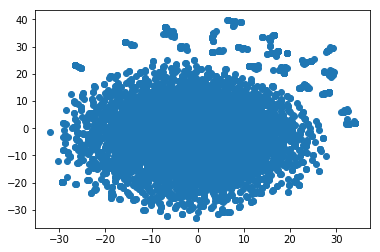

In [14]:
print("How are the clusters looking? Lets just inspect them with TSNE for visualization: ")
Y = tsne(np.float64(x_train_pred[0:5000]))
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()
"""
If we have used a variational autoencoder, it coud make sense to display just the inner representation:
print("Here we will take the first two coordinates from the inner representation and display it"
      "(useful when using variational autoencoder or autoencoder with just 2 units)")
plt.scatter(x_train_pred[:, 0], x_train_pred[:, 1])
plt.show()
"""
print("")

In [15]:
print("Idea: We could inspect the small clusters in the TSNE representation: \n")
point_inspect = [30, -20]  # input your own point

dists = [(i, (point_inspect[0]-item[0])*(point_inspect[0]-item[0]) +
          (point_inspect[1]-item[1])*(point_inspect[1]-item[1])) 
         for i, item in enumerate(Y)]
dists.sort(key=lambda item: item[1])
[" ".join(X_train_orig[item[0]]) for item in dists[0:5]]

Idea: We could inspect the small clusters in the TSNE representation: 



["A disappointing film . The story established our protagonist as Chrissy , a ' young ', rather sullen individual drifting , not doing much . Actually she does very little to move the narrative along so it didn ' t surprise me to see the focus shifting on her relatives . It ' s a pity though , Chrissy seem like interesting character . Story was predictable and at times felt quite formulated . So the question now is , when are we going to see the Campions , Jacksons , and the Tamahori ' s breaking ground with compelling , cinematically - told stories that will inspire , rather than entertain for the toll of two hours ? Technically , a disgusting shot film .",
 'My girlfriend has the habit of going to Blockbuster and choosing movies no - one has ever heard anything about . Admittedly , at times , it has led to some fun discoveries . Often times , the best that can be said is they definitely run an hour and a half . She brought home " Advice From A Caterpillar ." She was excited because t

## Conclusion and more ideas for experiments:
- Spoiler: **Even though the textual features use numbers, the autoencoder found them to not be so much frequent and decided they are the biggest anomalies.**
- Real life purpose of this autoencoder could then be: **To find a text, that has unusual distribution of characters.**
  - Could be upgraded to ignore numbers altogether, then it would process only text and find the outliers.
  - *Remember, this is just an example with easiest autoencoder architecture. For real life applications, different architectures and embeddings/ character models should be used. Also it is possible to use a trained model and inner representation can be its last layer.*
  
Ways to experiment with the code:
- The code can be tried out with embeddings
- Character level architectures can be used
- Varying the parameters can lead the model to perform differently
- Or empolying different model 


### When we know the purpose of the autoencoder, we can search the training set:

In [16]:
print("Give me sentence with this distribution of o's")
print("")
inspect_custom_sentence(u"Noooooooo! I use a looooot of Ooooooos!")
print("")
print("")
print("")
print("Give me sentence with numbers inside")
print("")
inspect_custom_sentence(u"1 2 3 4 5 6 7 8 9 10 11 ... You know that iam called the Count! Because I really love to count!")

Give me sentence with this distribution of o's

Reconstructed custom sentence (only using vocabulary): 

 
 --Original sentence reconstructed just from vocabulary: 
cookbook ! i use a lookout of sooooo ! ! ! ! ! ! ! ! ! ! ! !
--Predicted sentence reconstructed by autoencoder AND vocabulary: 
notebook ! i use a lookout of sooooo ! o o a a t a e a ! e !
--mse: 6.572770226909424e-05; ((different))

Most similar sentence in trained encoder's representation: 
Somebody owes Ang Lee an apology . Actually , a lot of people do . And I ' ll start



Give me sentence with numbers inside

Reconstructed custom sentence (only using vocabulary): 

 
 --Original sentence reconstructed just from vocabulary: 
1 2 3 4 5 6 7 8 9 10 11 ;) you know that aim called the count !
--Predicted sentence reconstructed by autoencoder AND vocabulary: 
19 23 2 0 8 9 9 6 9 16 21 ! yo note that aim laced the count !
--mse: 0.00012644489065734234; ((different))

Most similar sentence in trained encoder's representation: 

In [0]:
print("Give me sentence to train my pronounciation!")
print("")
inspect_custom_sentence(u"qwrt qwrt qwrt qwrt qwrt qwrt qwrt q w r t q w r t q w r t")

Give me sentence to train my pronounciation!

Reconstructed custom sentence (only using vocabulary): 

 
 --Original sentence reconstructed just from vocabulary: 
waqt waqt waqt waqt waqt waqt waqt q w r t q w r t q w r t !
--Predicted sentence reconstructed by autoencoder AND vocabulary: 
whit wore west west wire twin wait t w r t b w r t i w r t w
--mse: 3.4385971133244184e-05; ((different))

Most similar sentence in trained encoder's representation: 
Many people here say that this show is for kids only . Hm , when I was a kid (


# Thank you!

Links for literature and more examples (not only autoencoders, but also other visualizations used here):   


https://blog.keras.io/building-autoencoders-in-keras.html  
https://lvdmaaten.github.io/tsne/  
https://github.com/lvdmaaten/bhtsne/  
https://cs224d.stanford.edu/reports/OshriBarak.pdf  
https://hackernoon.com/how-to-autoencode-your-pok%C3%A9mon-6b0f5c7b7d97   
https://datascience.stackexchange.com/questions/29527/which-type-auto-encoder-gives-best-results-for-text   
https://www.reddit.com/r/MachineLearning/comments/2em084/el5_what_are_autoencoders_used_for/  
https://www.siarez.com/projects/variational-autoencoder  
IMDB dataset for sentient:
https://github.com/rossumai/mlprague18-nlp/blob/master/IMDB%20Sentiment.ipynb
  
  Bonus for everybody - colab notebook with character model (convolutional autoencoder): https://colab.research.google.com/drive/1DfLYljazmkxAwBCRt1AHbdtBU3xV0lPr ;) 